![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# Deep Learning - Using Neural Networks to classify CIFAR10 Images

Can you classify an image from the CIFAR10 image library using a Neural Network?

## Table of Contents

* [1. Introduction](#introduction)
* [2. Importing libraries](#libraries)
* [3. Importing and preparing the data](#data)
* [4. Neural Network models](#nn_models)
    * [4.1. Simplest model](#simplest_model)
        * [4.1.1. Model definition](#model_definition)
        * [4.1.2. Optimizer, error function](#optimizer_error)
        * [4.1.3. Model training](#training)
        * [4.1.4. Model evaluation](#evaluation)
    * [4.2. Adding more Dense layers](#more_dense_layers)
* [5. Models comparison](#comparison)


## 1. Introduction <a class="anchor" id="introduction"></a>

The main goal of this project is to test several Neural Networks configurations in order to do the proper classification of the CIFAR10 image dataset.

## 2. Importing libraries <a class="anchor" id="libraries"></a>

In [25]:
# data manipulation libraries
import numpy as np
import pandas as pd

# neural network libraries
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping

# plotting libraries
from matplotlib import pyplot as plt

# time libraries
import time
import datetime

In [26]:
# constants
EPOCHS = 100

## 3. Importing and preparing the data <a class="anchor" id="data"></a>

CIFAR10 is an existing dataset already available in the Keras library. These are already ready in train and test datasets (we'll need to create the validation dataset later).

**Important detail:**
> The neural network requires the inputs to be real numbers, and we will do it by forcing the division of the values ​​within the 28x28 matrices (which have values​​ from 0 to 255) by 255.0 (a real)

In [27]:
cifar10 = ks.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Let's explore the data to see what we have

In [28]:
print('Train: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Test: X = %s, y = %s' % (x_test.shape, y_test.shape))

Train: X = (50000, 32, 32, 3), y = (50000, 1)
Test: X = (10000, 32, 32, 3), y = (10000, 1)


For training, we have 50000 images of 32x32 pixels, split in the color channels (R, G, B). For testing, we only have 1000 images, but, obviously, of the same format as the training dataset.

Let's see what are the different categories we have in the dataset.

In [29]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

As expected, there are 10 categories that are already encoded into numbers. However, we will generate a label list for future plotting purposes.

In [30]:
cifar10_labels = [
'airplane', # id 0
'automobile', # id 1
'bird', # id 2
'cat', # id 3
'deer', # id 4
'dog', # id 5
'frog', # id 6
'horse', # id 7
'ship', # id 8
'truck', # id 9
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Let's show a sample of the images from the CIFAR10 dataset, to see if it looks anything like what we expect.

First, we see what types of data we have, then we map those arrays in a grayscale using the **. Get_cmap ()** method of Plotly with the first nine numbers of the dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


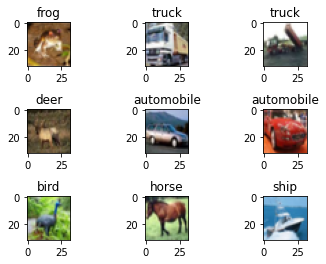

In [31]:
# Let's show a sample of the images of CIFAR10

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap = plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Let's start preparing the datasets for the models we will train. 

We are we going to validate while we train (very practical). We'll be removing the last 10000 entries in `x_train` for our validation dataset. 

In [32]:
# generating the validation dataset
x_val = x_train[-10000:]
y_val = y_train[-10000:]

# modifying the training dataset to exclude the validation dataset
x_train = x_train[:-10000]
y_train = y_train[:-10000]

When we add convolution layers, we need to "pre-treat the data", because **the convolution expects an array of 4 fields** (more like coloured "images"), in the case of MNIST. However, CIFAR10 already has the right shape, so we don't have to do anything, but as we always say: you should better check its size.

Therefore, when exiting the Convolution, you always have to do a Flatten, because FullDense layers expect arrays, not matrices !!

Let's validate the format.

In [33]:
# We validate the result
print('Train: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Test: X = %s, y = %s' % (x_test.shape, y_test.shape))
print('Validation: X = %s, y = %s' % (x_val.shape, y_val.shape))

Train: X = (40000, 32, 32, 3), y = (40000, 1)
Test: X = (10000, 32, 32, 3), y = (10000, 1)
Validation: X = (10000, 32, 32, 3), y = (10000, 1)


----------

## 4. Neural Network Models <a class="anchor" id="nn_models"></a>

In the following sections, we are going to define and train up to 10 different Neural Network models to see which arquitecture is providing the best accuracy.

Nonetheless, before starting with the models let's set a couple of previous tunings that will help us later with the training

In [34]:
# defining callbacks for EarlyStopping
callback_loss = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
callback_accuracy = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True)

# list to keep the model results for final comparison
model_evaluations = []

### 4.1. Simplest model <a class="anchor" id="simplest_model"></a>

Let's start with the simplest model possible with a single Dense Layer

#### 4.1.1. Model definition <a class="anchor" id="model_definition"></a>


In [35]:
model = ks.Sequential()

# Neural Network Layers
model.add(ks.layers.Flatten(input_shape = (32, 32, 3)))
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

# review model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               393344    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


#### 4.1.2. Optimizer, error function <a class="anchor" id="optimizer_error"></a>


In [36]:
# compiling model
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### 4.1.3. Training <a class="anchor" id="training"></a>

In order to train the model we have setup a global constant of 100 EPOCHS, which we expect to never reach, as we have implemented a callback to stop training once the accuracy or the cross entropy loss doesn't improve that much. Additionally, we are going to keep the best weights to get the most optimal results for the model.

In [37]:
# calculating computational time
t = time.perf_counter()

# training model
history = model.fit(
                    x_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    use_multiprocessing = False, 
                    batch_size = 128, 
                    validation_data = (x_val, y_val),
                    callbacks = [callback_accuracy, callback_loss]
          )

# show total elapsed time
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('\nTraining time:', elapsed_time)

Epoch 1/100
313/313 [==============================] - 2s 6ms/step - loss: 1.9648 - accuracy: 0.3016 - val_loss: 1.8696 - val_accuracy: 0.3410
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 1.8042 - accuracy: 0.3650 - val_loss: 1.7916 - val_accuracy: 0.3691
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 1.7419 - accuracy: 0.3894 - val_loss: 1.7391 - val_accuracy: 0.3910
Epoch 4/100
313/313 [==============================] - 1s 5ms/step - loss: 1.6961 - accuracy: 0.4038 - val_loss: 1.7206 - val_accuracy: 0.3916
Epoch 5/100
313/313 [==============================] - 1s 5ms/step - loss: 1.6509 - accuracy: 0.4214 - val_loss: 1.6877 - val_accuracy: 0.4089
Epoch 6/100
313/313 [==============================] - 1s 5ms/step - loss: 1.6150 - accuracy: 0.4333 - val_loss: 1.6473 - val_accuracy: 0.4201
Epoch 7/100
313/313 [==============================] - 2s 5ms/step - loss: 1.5915 - accuracy: 0.4391 - val_loss: 1.6712 - val_accuracy: 0.4119

#### 4.1.4. Evaluation <a class="anchor" id="evaluation"></a>

Let's obtain a graph of how the entropy and the accuracy evolve in each epoch in the training data and in the validation

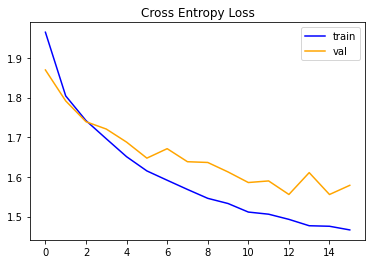

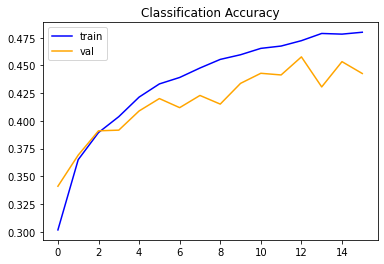

In [38]:
# cross entropy loss plot
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

# accuracy plot
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

The callbacks have stopped the model training at EPOCH = 16, as we reached the top accuracy at EPOCH = 13 (from which we got the best parameters). However, we have seen that the validation accuracy looks really bad (around 40%), so our hopes are not that high fo the test accuracy, but let's check it out.

In [39]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy for the model -> {round((acc * 100.0), 4)} %')

Test Accuracy for the model -> 46.41 %


As expected, the model is really bad. With this accuracy we can say that this is a really bad model that requires an improvement.

Let's see what kind of predictions we're getting on the test set (let's paint the images and their classifications).

In [40]:
predictions = model.predict(x_test)

In [41]:
# plotting helper functions
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')

def plot_cifar_results(predictions, x_test, y_test, num_rows = 5, num_cols = 4):
    i = 0
    for l in cifar10_labels:
        print(i, l)
        i += 1

    num_images = num_rows * num_cols
    start = np.random.randint(1000 - num_images)
    plt.figure(figsize = (2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i +1)
        plot_image(i + start, predictions[i + start], y_test, x_test)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i + start, predictions[i + start], y_test)
    plt.tight_layout()
    plt.show()

We draw the first images, with the predictions and their real values ​​(a total of 20 images, so as not to abuse your laptops)

We color the correct predictions in blue and the failures in red. Although I have printed the labels first so that we have a reference to the graphic.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


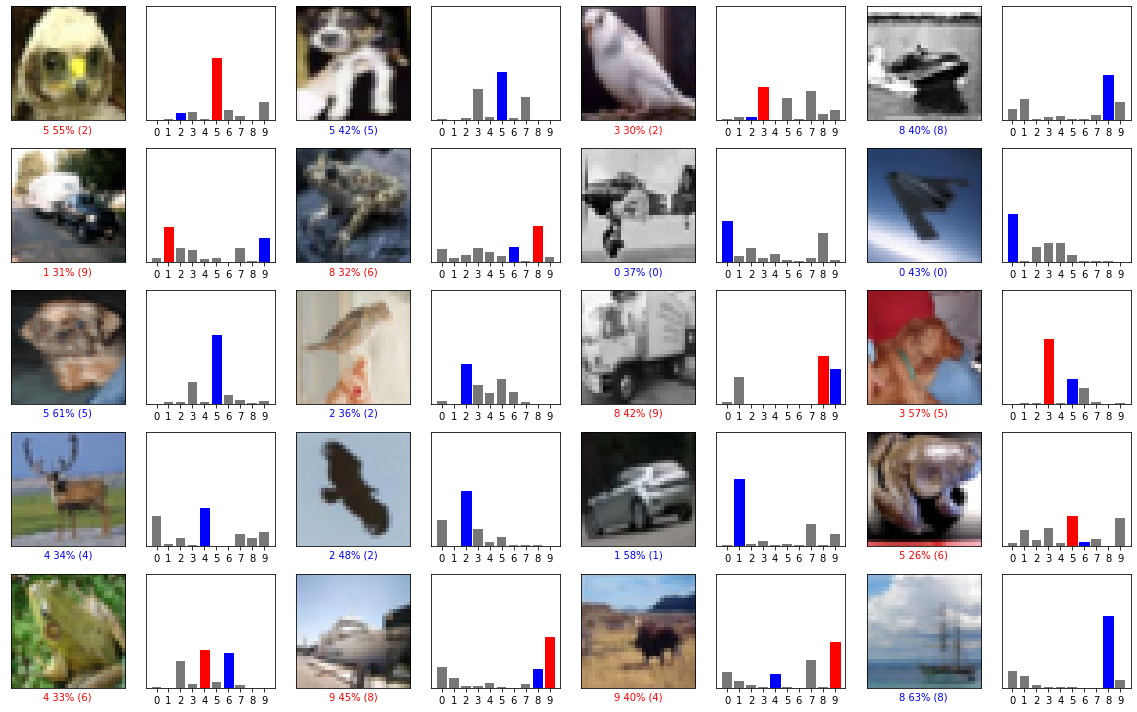

In [42]:
plot_cifar_results(predictions, x_test, y_test)

Let's see if we can build up the previous model to improve the accuracy, but before that, let's store the accuracy of this model so we can compare it at the end with all the other models.

In [43]:
# keeping accuracies for a final analysis
model_evaluations.append(
    {
        'model_name': 'Single Flatten Layer',
        'accuracy': acc
    }
)

### 4.2. Adding more Dense layers <a class="anchor" id="more_dense_layers"></a>

## 5. Models comparison <a class="anchor" id="comparison"></a>

In [46]:

df = pd.DataFrame(model_evaluations)


In [47]:
df

,model_name,accuracy
0,Single Flatten Layer,0.4641


In [45]:
# TODO: Keep the model for later

model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(32, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))